<a href="https://colab.research.google.com/github/cipz/AlgoritmiAvanzati/blob/master/Homework3/hm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Karger algorithm

In [1]:
import copy
import sys
import time
import pandas as pd
import random
import math
from collections import defaultdict

In [2]:
class Graph:
    def __init__(self):
        self.n_nodes, self.n_edges = 0, 0 # number of nodes, edges
        self.nodes = defaultdict() # adjacency lists
        self.edges = [] # list of edges

    def addEdge(self, v1:int, v2:int):
        self.nodes[v1].append(v2)
        if (v2, v1) not in (self.edges):
          self.edges.append((v1, v2))
          self.n_edges += 1

    def buildGraph(self, data):
        self.n_nodes = len(data)
        for i in range (1, len(data) + 1):
          self.nodes[i] = []
        for v in data:
          for i in range (1, len(v)):
            self.addEdge(v[0], v[i])
                

## Reading the input

In [3]:
def readInput(path: str):
    """
    :param path: path to the dataset
    :return: input dataset
    """
    lines = open(path, "r").read().split("\n")
    input = []
    for line in range(len(lines)-1):
        input.append(list(map(int, lines[line].split()))) # transform list of strings to list of integers

    return input

## Deep copy

In [4]:
def graphCopy(graph: Graph):
    """
    :param graph: graph object to copy
    :return: deep copy of the input graph
    """
    newGraph = Graph()
    newGraph.n_nodes, newGraph.n_edges = graph.n_nodes, graph.n_edges
    newGraph.nodes = copy.deepcopy(graph.nodes)
    newGraph.edges = copy.deepcopy(graph.edges)
    return newGraph

## Karger implementation

In [5]:
def fullContraction(graph):
    """
    :param graph: graph object
    :return: minimum cut value
    """
    while graph.n_nodes > 2:

        e = graph.edges[random.randrange(0, graph.n_edges)] # select a random edge 

        # Contraction
        id = "Z_" + str(e[0]) + str(e[1]) # build a new node
        graph.nodes[id] = [] # initialize adjacency list

        del_edges = 0
        delete_list = []
        
        for i in range(0, len(graph.edges)): # select the indexes of the edges to remove
          if graph.edges[i][0] == e[0] or graph.edges[i][0] == e[1] or graph.edges[i][1] == e[0] or graph.edges[i][1] == e[1]: # delete all incident edges of e
            delete_list.append(i)
            del_edges += 1

        cont = 0
        for i in delete_list: 
          graph.edges.pop(i - cont)
          cont += 1
        
        # update adjacency lists
        add_edges = 0
        for v in graph.nodes[e[0]]:
          if v != e[1]:
            graph.nodes[id].append(v)
            graph.edges.append((id, v))
            graph.n_edges += 1
            graph.nodes[v].remove(e[0])
            graph.nodes[v].append(id)

        for v in graph.nodes[e[1]]:
          if v != e[0]:
            graph.nodes[id].append(v)
            graph.edges.append((id, v))
            add_edges += 1
            graph.nodes[v].append(id)
            graph.nodes[v].remove(e[1])        

        graph.nodes[e[0]] = []
        graph.nodes[e[1]] = []

        graph.n_nodes -= 1 # update the number of nodes
        graph.n_edges -= (del_edges - add_edges) # update the number of edges

    return graph.n_edges

def karger(graphs, max_time, exact_result):
    """
    :param graphs: list of the same graph object
    :param max_time: maximum computation time
    :param exact_result: exact solution
    :return: minumum cut value, mean of all full contraction operation and the discovery time
    """
    min = math.inf
    discovery_time = 0 # if the discovery time is 0 after the execution, the exact value is not found
    starting_discovery_time = time.time()
    contraction_count = 0
    full_contractions_time = 0
    for g in graphs:
      if time.time() > max_time: # check the execution time limit
        mean_full_contraction_time = full_contractions_time / contraction_count # compute the average full contraction time
        return min, '%.5f'%mean_full_contraction_time, '%.5f'%discovery_time
      else:
        contraction_count += 1
        start_contraction_time = time.time()
        t = fullContraction(g) # execute full contraction
        full_contractions_time += (time.time() - start_contraction_time)
        if t < min: # check if the result is better of the current result
           min = t
           if min == exact_result: # check if the result is equal to the exact result
             discovery_time = time.time() - starting_discovery_time
    mean_full_contraction_time = full_contractions_time / contraction_count # compute the average full contraction time
    return min, '%.5f'%mean_full_contraction_time, '%.5f'%discovery_time

# **Main**

In [6]:
def execute_alg(dataset_name):
    import time
    dataset = readInput(path + dataset_name)

    print()
    print("Executing algorithm on {} dataset file".format(dataset_name))

    graph = Graph()
    graph.buildGraph(dataset)

    k = int((graph.n_nodes**2 / 2) * math.log(graph.n_nodes)) # compute k value to obtain probability of error <= 1/n
    if k > 10000: 
      k = 10000
    random.seed(random.randrange(1, 1000))
    graph_set = []
    for i in range(0, k):
      graph_set.append(graphCopy(graph))

    starting_time = time.time()
    max_time = 60 # max computation time 60 sec 
    result, mean_full_contraction_time, discovery_time = karger(graph_set, starting_time + max_time, inputs[dataset_name])

    time = '%.5f'%(time.time() - starting_time)
    error = '%.2f'%(((result - inputs[dataset_name]) / inputs[dataset_name]*100))
    
    print("Solution found: {}".format(result))
    print("Time spent: \t{}".format(time))
    print("Mean FC time: \t{}".format(mean_full_contraction_time))
    print("Discovery time: \t{}".format(discovery_time))
    print("Error %: \t{}".format(error))
    print()
    return result, time, mean_full_contraction_time, discovery_time, error

In [7]:
path = "mincut_dataset/"
inputs = {
    "input_random_1_6.txt": 2,
    "input_random_2_6.txt": 1,
    "input_random_3_6.txt": 3,
    "input_random_4_6.txt": 4,
    "input_random_5_10.txt": 4,
    "input_random_6_10.txt": 3,
    "input_random_7_10.txt": 2,
    "input_random_8_10.txt": 1,
    "input_random_9_25.txt": 7,
    "input_random_10_25.txt": 6,
    "input_random_11_25.txt": 8,
    "input_random_12_25.txt": 9,
    "input_random_13_50.txt": 15,
    "input_random_14_50.txt": 16,
    "input_random_15_50.txt": 14,
    "input_random_16_50.txt": 10,
    "input_random_17_75.txt": 19,
    "input_random_18_75.txt": 15,
    "input_random_19_75.txt": 18,
    "input_random_20_75.txt": 16,
    "input_random_21_100.txt": 22,
    "input_random_22_100.txt": 23,
    "input_random_23_100.txt": 19,
    "input_random_24_100.txt": 24,
    "input_random_25_125.txt": 34,
    "input_random_26_125.txt": 29,
    "input_random_27_125.txt": 36,
    "input_random_28_125.txt": 31,
    "input_random_29_150.txt": 37,
    "input_random_30_150.txt": 35,
    "input_random_31_150.txt": 41,
    "input_random_32_150.txt": 39,
    "input_random_33_175.txt": 42,
    "input_random_34_175.txt": 45,
    "input_random_35_175.txt": 53,
    "input_random_36_175.txt": 43,
    "input_random_37_200.txt": 54,
    "input_random_38_200.txt": 52,
    "input_random_39_200.txt": 51,
    "input_random_40_200.txt": 61
}


res = []
for dataset_name in inputs.keys():
  res.append(execute_alg(dataset_name))


Executing algorithm on input_random_1_6.txt dataset file
Solution found: 2
Time spent: 	0.00164
Mean FC time: 	0.00005
Discovery time: 	0.00030
Error %: 	0.00


Executing algorithm on input_random_2_6.txt dataset file
Solution found: 1
Time spent: 	0.00121
Mean FC time: 	0.00004
Discovery time: 	0.00005
Error %: 	0.00


Executing algorithm on input_random_3_6.txt dataset file
Solution found: 3
Time spent: 	0.00156
Mean FC time: 	0.00005
Discovery time: 	0.00007
Error %: 	0.00


Executing algorithm on input_random_4_6.txt dataset file
Solution found: 4
Time spent: 	0.00172
Mean FC time: 	0.00005
Discovery time: 	0.00008
Error %: 	0.00



In [8]:
header = pd.MultiIndex.from_product([['Karger'], ['Soluzione', 'Tempo(s)', 'Tempo Full Contraction(s)', 'Discovery time(s)', 'Errore(%)']], names=['','Istanza'])
table_properties = {'font-size': '10pt','border-color': 'black','border-style' :'solid' ,'border-width': '1px','padding': '5px','text-align': 'center'}
header_properties = [{'selector': 'th', 'props': [('font-size', '10pt'),('padding-top', '5px'),('padding-bottom', '5px'),('padding-left', '10px'),('padding-right', '10px'),('border-color', 'black'),('border-style' ,'solid') ,('border-width', '1px')]}]

df = pd.DataFrame(res, index=inputs.keys(), columns=header).style.set_properties(**table_properties).set_table_styles(header_properties)
df

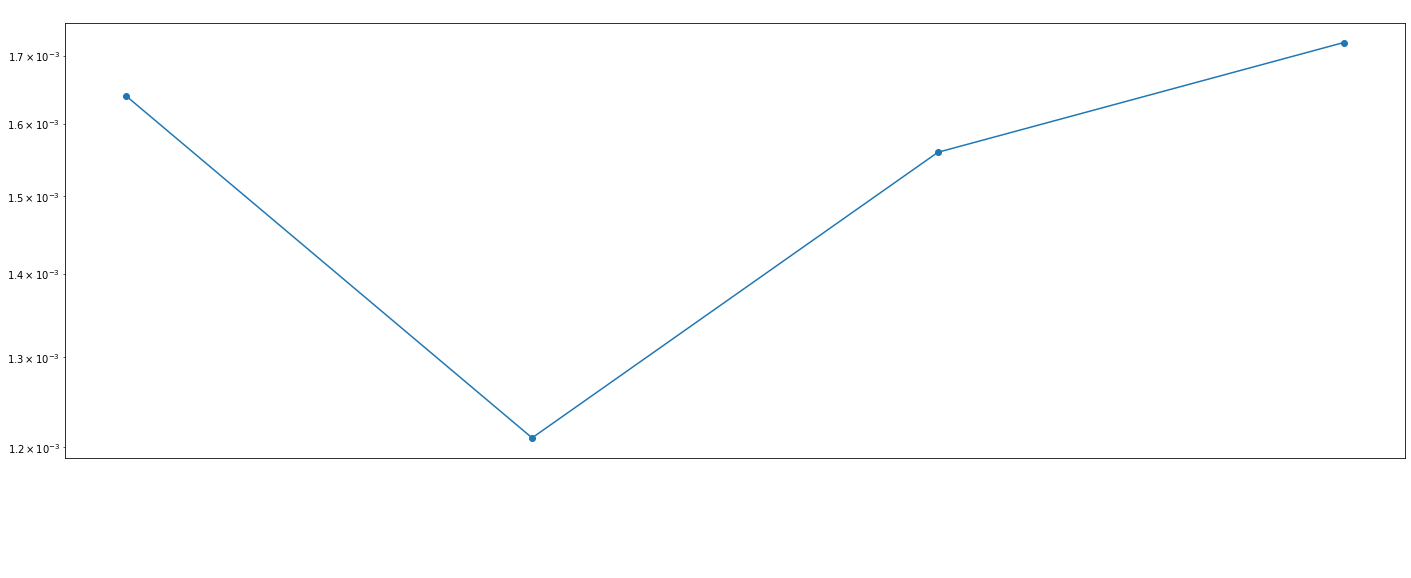

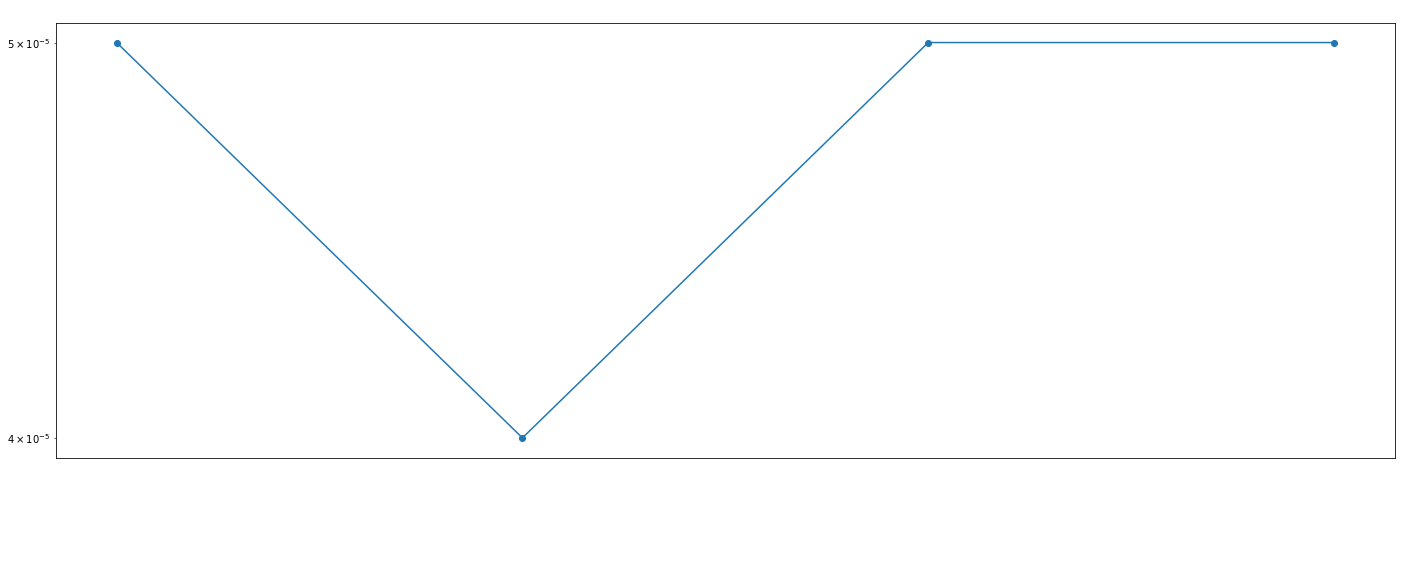

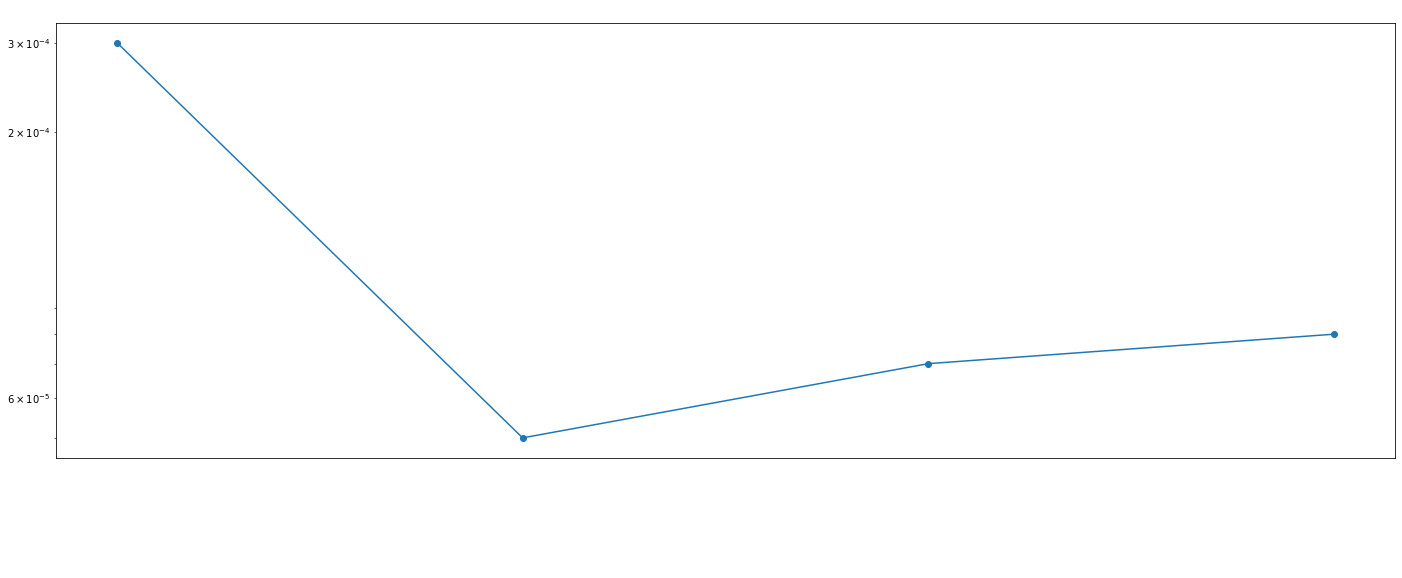

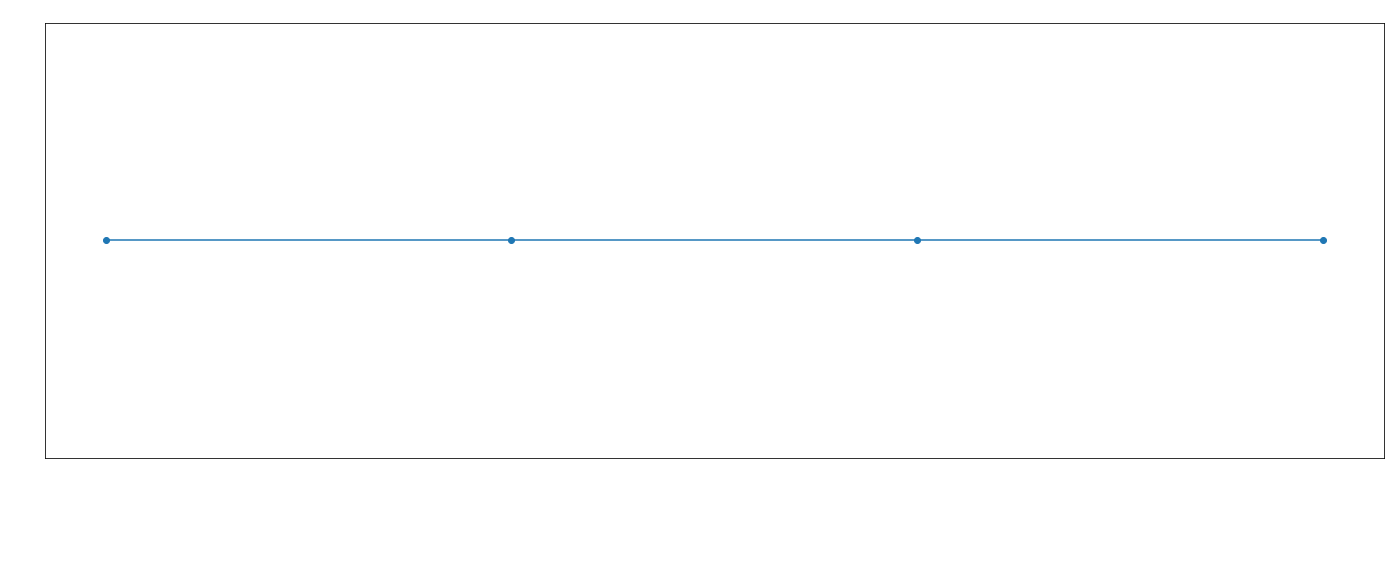

In [9]:
import matplotlib.pylab as plt
exec_times = []
mean_fc_times = []
discovery_times = []
errors = []
for r in res:
  exec_times.append(float(r[1]))
  mean_fc_times.append(float(r[2]))
  discovery_times.append(float(r[3]))
  errors.append(float(r[4]))

fig1, ax1 = plt.subplots(nrows=1, ncols=1)
fig2, ax2 = plt.subplots(nrows=1, ncols=1)
fig3, ax3 = plt.subplots(nrows=1, ncols=1)
fig4, ax4 = plt.subplots(nrows=1, ncols=1)

fig1.set_figwidth(24)
fig1.set_figheight(8)
fig2.set_figwidth(24)
fig2.set_figheight(8)
fig3.set_figwidth(24)
fig3.set_figheight(8)
fig4.set_figwidth(24)
fig4.set_figheight(8)

ax1.plot(list(input.keys()), exec_times)
ax1.scatter(list(input.keys()), exec_times)
ax1.set_xticklabels(list(input.keys()),rotation=70)
ax1.set_title("Execution time(s) Comparison")
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.title.set_color('white')
ax1.set_yscale("log")
fig1.show()

ax2.plot(list(input.keys()), mean_fc_times)
ax2.scatter(list(input.keys()), mean_fc_times)
ax2.set_xticklabels(list(input.keys()),rotation=70)
ax2.set_title("Mean FC time(s) Comparison")
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
ax2.title.set_color('white')
ax2.set_yscale("log")
fig2.show()

ax3.plot(list(input.keys()), discovery_times)
ax3.scatter(list(input.keys()), discovery_times)
ax3.set_xticklabels(list(input.keys()),rotation=70)
ax3.set_title("Discovery time(s) Comparison")
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
ax3.title.set_color('white')
ax3.set_yscale("log")
fig3.show()

ax4.plot(list(input.keys()), errors)
ax4.scatter(list(input.keys()), errors)
ax4.set_xticklabels(list(input.keys()),rotation=70)
ax4.set_title("Error(%) Comparison")
ax4.tick_params(axis='x', colors='white')
ax4.tick_params(axis='y', colors='white')
ax4.title.set_color('white')
fig4.show()